In [38]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mlp import MLP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import MinMaxScaler, _inset_spectra, scaled_tickformat, get_twod_grid
import json 

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [39]:
DATA_DIR = "./output/"
ITERATION = 6
with open('/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

In [40]:
# Load trained MLP model for p(z|c)
train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%ITERATION, map_location=device)
train_z_mean = torch.load(DATA_DIR+'/train_z_mean_%d.pt'%ITERATION, map_location=device)
train_z_std = torch.load(DATA_DIR+'/train_z_std_%d.pt'%ITERATION, map_location=device)
mlp = MLP(train_x, train_z_mean, train_z_std)
mlp_state_dict = torch.load(DATA_DIR+'/comp_model_%d.pt'%(ITERATION), map_location=device)
mlp.load_state_dict(mlp_state_dict)

# Load trained NP model for p(y|z)
NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%(ITERATION), map_location=device))

design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [41]:
def from_comp_to_spectrum(t, c, comp_model, np_model):
    ci = torch.tensor(c).to(device)
    z_mu, z_std = comp_model.mlp(ci)
    z_dist = torch.distributions.Normal(z_mu, z_std)
    z = z_dist.sample(torch.Size([100]))
    t = torch.from_numpy(t).repeat(100, 1, 1).to(device)
    t = torch.swapaxes(t, 1, 2)
    y_samples, _ = np_model.xz_to_y(t, z)

    mean_pred = y_samples.mean(dim=0, keepdim=True)
    sigma_pred = y_samples.std(dim=0, keepdim=True)
    mu_ = mean_pred.cpu().squeeze()
    sigma_ = sigma_pred.cpu().squeeze() 

    return mu_, sigma_ 

In [42]:
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)
bounds = expt.bounds.cpu().numpy()

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shapes: (11, 2) (11, 101)
Loading data from iteration 3 with shapes: (11, 2) (11, 101)
Loading data from iteration 4 with shapes: (11, 2) (11, 101)
Loading data from iteration 5 with shapes: (11, 2) (11, 101)


In [43]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    
    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_2318/1967543172.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


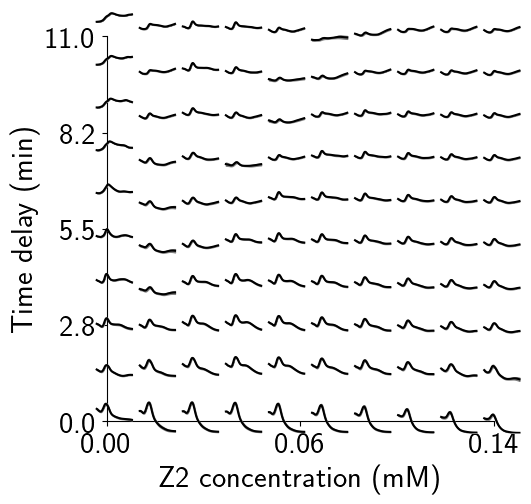

In [44]:
N_GRID_SPACING = 10
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    bounds = expt.bounds.cpu().numpy()
    scaler_x = MinMaxScaler(design_space_bounds[0][0], design_space_bounds[0][1])
    scaler_y = MinMaxScaler(design_space_bounds[1][0], design_space_bounds[1][1])

    ax.xaxis.set_major_formatter(lambda x, pos : scaled_tickformat(scaler_x, x, pos))
    ax.yaxis.set_major_formatter(lambda y, pos : scaled_tickformat(scaler_y, y, pos))
    grid_comps = get_twod_grid(N_GRID_SPACING, bounds)
    grid_spectra = np.zeros((grid_comps.shape[0], len(expt.t), 2))
    with torch.no_grad():
        for i, ci in enumerate(grid_comps):
            mu, sigma = from_comp_to_spectrum(expt.t, ci, mlp, NP)
            mu_ = mu.cpu().squeeze().numpy()
            sigma_ = sigma.cpu().squeeze().numpy()
            grid_spectra[i, :, 0] = mu_ 
            grid_spectra[i, :, 1] = sigma_
            norm_ci = np.array([scaler_x.transform(ci[0]), scaler_y.transform(ci[1])])
            loc_ax = ax.transLimits.transform(norm_ci)
            ins_ax = ax.inset_axes([loc_ax[0]-0.03,loc_ax[1]-0.03,0.1,0.1])
            ins_ax.plot(expt.t, mu_, color="k")
            ins_ax.fill_between(expt.t, mu_-sigma_, mu_+sigma_, color='grey')
            ins_ax.set_ylim([0, 2.0])
            ins_ax.axis('off') 
    prettify_axis(ax)
    plt.savefig("./figures/predicted_grid_%d.png"%ITERATION)
    plt.show()

## Use ratio as x-axis

In [45]:
def prettify_axis_v2(ax):
    ax.set_xlabel('[Z2]/[Z2M246I]')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*plot_bounds[:,0])
    ax.set_ylim(*plot_bounds[:,1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    return ax

In [46]:
volumes = pd.read_csv("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/2D/repeat/volumes_repeat_071724.csv")
times = pd.read_csv("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/2D/repeat/times_repeat_071724.csv")
conc_peptide_A = (0.3*87)/(volumes[["Water", "HEPES", "Z2M246I"]].sum(axis=1).values)
conc_peptide_B = (0.3*volumes["Z2"].values)/(280.0)
ratio_BA = conc_peptide_B/(conc_peptide_A)
plot_bounds = np.asarray([(ratio_BA.min(), ratio_BA.max()), (0.0,11.0)]).T

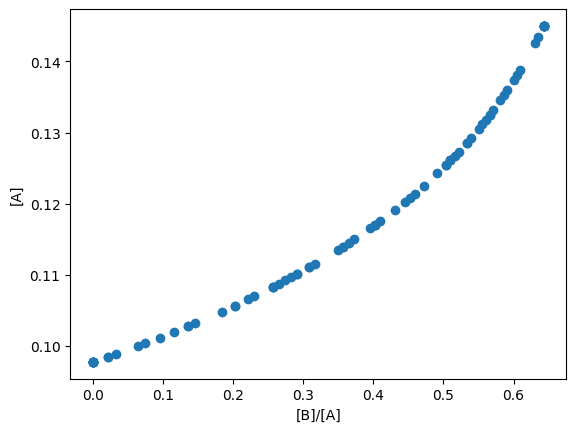

In [47]:
fig, ax = plt.subplots()
ax.scatter(ratio_BA, conc_peptide_A)
ax.set_xlabel("[B]/[A]")
ax.set_ylabel("[A]")
plt.show()

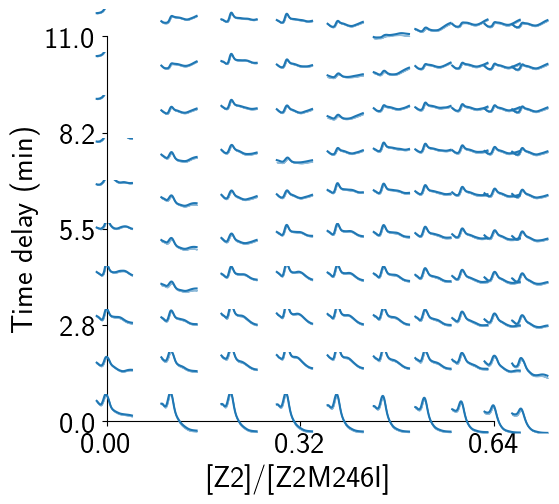

In [48]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    bounds = expt.bounds.cpu().numpy()
    scaler_x = MinMaxScaler(plot_bounds[0,0], plot_bounds[1,0])
    scaler_y = MinMaxScaler(plot_bounds[0,1], plot_bounds[1,1])

    ax.xaxis.set_major_formatter(lambda x, pos : scaled_tickformat(scaler_x, x, pos))
    ax.yaxis.set_major_formatter(lambda y, pos : scaled_tickformat(scaler_y, y, pos))
    with torch.no_grad():
        for i, ci in enumerate(grid_comps):
            conc_B = (0.3*ci[0])/(280.0)
            conc_A = (0.3*87)/(280-ci[0])
            ri = conc_B/conc_A
            norm_ci = np.array([scaler_x.transform(ri), scaler_y.transform(ci[1])])
            loc_ax = ax.transLimits.transform(norm_ci)
            ins_ax = ax.inset_axes([loc_ax[0]-0.03,loc_ax[1]-0.03,0.1,0.1])
            ins_ax.plot(expt.t, grid_spectra[i,:,0], color="tab:blue")
            ins_ax.fill_between(expt.t, 
                                grid_spectra[i,:,0]-grid_spectra[i,:,1], 
                                grid_spectra[i,:,0]-grid_spectra[i,:,1], 
                                color='tab:blue', alpha=0.5
                                )
            ins_ax.set_ylim([0, 1.5])
            ins_ax.axis('off') 
    prettify_axis_v2(ax)
    plt.show()